In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from scripts.utils.data_loading import load_data

In [3]:
%matplotlib inline

In [4]:
DATA_DIRECTORY = '../data/limit-order-book/XXBTZUSD'

In [5]:
start = datetime(2020, 2, 9, 22, 1, 0)
end = datetime(2020, 2, 9, 23, 1, 0)  # 2020-02-10 06:18:43

In [6]:
df = load_data(DATA_DIRECTORY, start, end)

2it [00:02,  1.09s/it]


In [7]:
df['query_datetime'] = pd.to_datetime(df['query_time'], unit='s')

In [8]:
df.shape

(1424800, 6)

In [9]:
df.query_datetime.min()

Timestamp('2020-02-10 05:48:13.298475504')

In [10]:
df.query_datetime.max()

Timestamp('2020-02-10 06:48:15.380545139')

In [23]:
def plot_order_book(ob, relprice_lim):
    """Plots the cumulative volume and order distribution of the order book.
    
    Paramaters
    ----------
    ob : dataframe
        Order book data frame with columns type, price, volume, cumvolume, relprice.
    """
    
    ob['cumvolume'] = ob[['type', 'volume']].groupby('type').cumsum()  # assumes rows are sorted
    
    # add relprice
    minask = ob.loc[ob['type'] == 'a', 'price'].min()
    maxbid = ob.loc[ob['type'] == 'b', 'price'].max()
    spread = minask - maxbid
    midprice = (minask + maxbid) / 2
    ob['relprice'] = 100 * (ob['price'] - midprice) / midprice
    ob = ob[((ob['relprice'] < relprice_lim[1]) & (ob['type'] == 'a')) | ((ob['relprice'] > relprice_lim[0]) & (ob['type'] == 'b'))]
    
    # extract data series from df
    ask_prices = ob.loc[ob['type'] == 'a', 'price']
    ask_relprices = ob.loc[ob['type'] == 'a', 'relprice']
    ask_volumes = ob.loc[ob['type'] == 'a', 'volume']
    ask_cumvolumes = ob.loc[ob['type'] == 'a', 'cumvolume']
    bid_prices = ob.loc[ob['type'] == 'b', 'price']
    bid_relprices = ob.loc[ob['type'] == 'b', 'relprice']
    bid_volumes = ob.loc[ob['type'] == 'b', 'volume']
    bid_cumvolumes = ob.loc[ob['type'] == 'b', 'cumvolume']

    # plot cum vol plot
    fig, ax = plt.subplots(2, 1, figsize=(7, 6))  # sharex='col'
    ax[0].fill_between(bid_relprices, bid_cumvolumes, facecolor='maroon', edgecolor='k', alpha=0.7, zorder=10, label='bids')
    ax[0].fill_between(ask_relprices, ask_cumvolumes, facecolor='dimgrey', edgecolor='k', alpha=0.7, zorder=10, label='asks')
    ax[0].set_xlim([min(bid_relprices.min(), ask_relprices.min()), max(bid_relprices.max(), ask_relprices.max())])
    ax[0].set_ylim([0, 1.05* max(bid_cumvolumes.max(), ask_cumvolumes.max())])
    ax[0].set_xlabel('Distance to midprice (%)')
    ax[0].set_ylabel('Cumulative Volume')
    ax[0].legend(loc='upper center', facecolor='white', framealpha=1, frameon=False)
    
    # plot order distribution
    ax[1].stem(bid_prices, bid_volumes, 'maroon', markerfmt=' ', label='bids')
    ax[1].stem(ask_prices, ask_volumes, 'k', markerfmt=' ', label='asks')
    ax[1].set_ylim([0, 1.05* max(bid_volumes.max(), ask_volumes.max())])
    ax[1].set_xlabel('Price')
    ax[1].set_ylabel('Volume')
    
    plt.tight_layout()
    plt.savefig('/home/maxlamberti/Desktop/BTC_LOB.png', dpi=400)
    
    plt.show()

In [13]:
subdf = df[df['query_datetime'].between(datetime(2020, 2, 10, 6, 18, 30), datetime(2020, 2, 10, 6, 20, 10))]

In [14]:
timeseries, midpriceseries, spreadseries = [], [], []
for ts, grp in subdf.groupby('query_datetime'):
    minask = grp.loc[grp['type'] == 'a', 'price'].min()
    maxbid = grp.loc[grp['type'] == 'b', 'price'].max()
    midprice = (minask + maxbid) / 2
    spread = minask - maxbid
    timeseries.append(ts)
    midpriceseries.append(midprice)
    spreadseries.append(spread)

/home/maxlamberti/anaconda3/envs/AFP_ENV/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


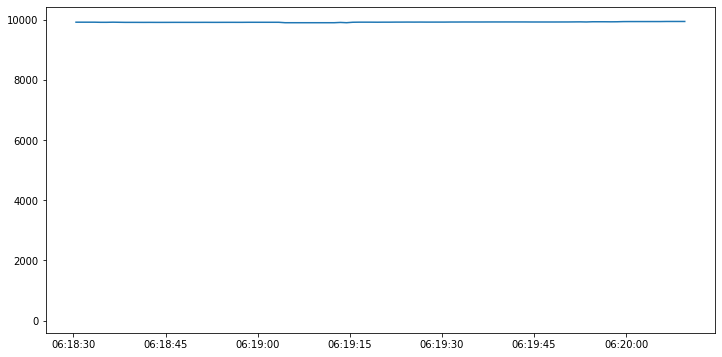

In [15]:
plt.figure(figsize=(12, 6))
plt.vlines(datetime(2020, 2, 10, 6, 18, 43), 84.1, 84.2)
plt.vlines(datetime(2020, 2, 10, 6, 18, 44), 84.1, 84.2)
plt.plot(timeseries, midpriceseries);

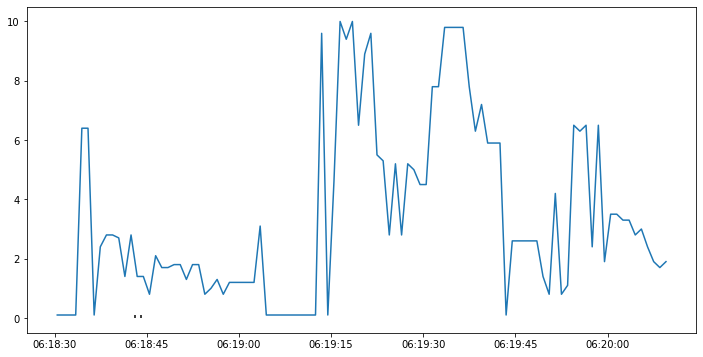

In [16]:
plt.figure(figsize=(12, 6))
plt.vlines(datetime(2020, 2, 10, 6, 18, 43), 0, 0.1)
plt.vlines(datetime(2020, 2, 10, 6, 18, 44), 0, 0.1)
plt.plot(timeseries, spreadseries);

2020-02-10 06:18:30.422776222


/home/maxlamberti/anaconda3/envs/AFP_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/maxlamberti/anaconda3/envs/AFP_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/maxlamberti/anaconda3/envs/AFP_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added

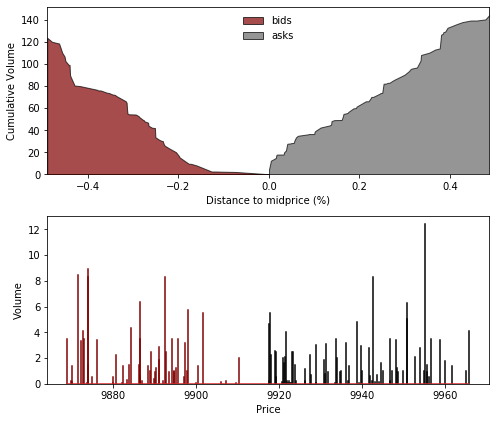

In [24]:
for ts, grp in subdf.groupby('query_datetime'):
    print(ts)
    plot_order_book(grp[['price', 'volume', 'timestamp', 'type']], relprice_lim=(-0.5, 0.5))
    break


In [12]:
ask_group = df[df['type'] == 'a'].groupby('query_datetime')
bid_group = df[df['type'] == 'b'].groupby('query_datetime')

In [13]:
ask_price = ask_group.price.min()
bid_price = bid_group.price.max()

In [14]:
spread = ask_price - bid_price

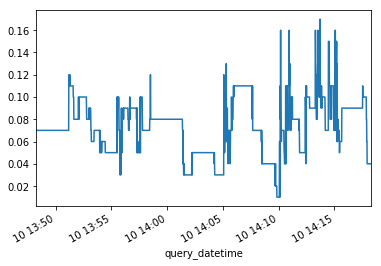

In [15]:
spread.plot();

In [ ]:
# get order
# look at how order book looks after execution